In [24]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [25]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data               # The numeric value of this node
        self._prev = set(_children)    # Keep track of the input nodes that created this node
        self._op = _op                 # Store the operator for debugging/graph visualization
        self.label = label
        self.grad = 0.0

    def __repr__(self):
        """
        Returns a readable string representation of the Value object.
        This helps when printing or debugging.
        """
        return f"Value: data = {self.data}"

    def __add__(self, other):
        """
        Defines the '+' operator for Value objects.

        When we do `a + b`, this method:
          1. Creates a new Value node with data = a.data + b.data
          2. Records (a, b) as its _children
          3. Tags the operation as '+'

        Returns:
            Value: A new Value object representing the sum.
        """
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        """
        Defines the '*' operator for Value objects.

        When we do `a * b`, this method:
          1. Creates a new Value node with data = a.data * b.data
          2. Records (a, b) as its _children
          3. Tags the operation as '*'

        Returns:
            Value: A new Value object representing the product.
        """
        out = Value(self.data * other.data, (self, other), '*')
        return out


a = Value(2.0, label='a')   
b = Value(3.0, label='b')  
c = Value(5.0, label='c')   
f = Value(-9.0, label='f')

e = a*b; e.label = 'e'

d = e + c; d.label='d'
L = d*f; L.label='L'
print(L)

Value: data = -99.0


In [26]:
d._prev

{Value: data = 5.0, Value: data = 6.0}

In [27]:
d._op

'+'

In [28]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [29]:
L.grad = 1.0

#### L = d * f
#### dL/dd = f

#### (f(x+h) - f(x)) / h
#### ((d+h)* f - d * f ) / h
#### (h * f) / h
#### f

## Derivation using the definition of a derivative

### Given:
$L = d \times f$

### Therefore:
$\frac{dL}{dd} = f$

---

## Proof using the limit definition

$$
\frac{dL}{dd} = \lim_{h \to 0} \frac{L(d+h) - L(d)}{h}
$$

Substitute $L = d \times f$:

$$
\frac{dL}{dd} = \lim_{h \to 0} \frac{(d+h)f - df}{h}
$$

Simplify the numerator:

$$
\frac{dL}{dd} = \lim_{h \to 0} \frac{hf}{h}
$$

Cancel $h$:

$$
\frac{dL}{dd} = f
$$

---

###  Result:

$$
\boxed{\frac{dL}{dd} = f}
$$

dL/de = 5

dL/da = (dL/de) * (de * da)


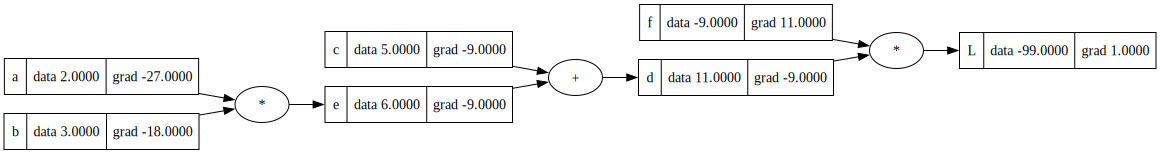

In [53]:
draw_dot(L)

## Chain Rule Calculation

Given:
$$\frac{dL}{de} = -9$$

$$e = a \times b$$

$$\frac{de}{da} = b$$

Therefore:
$$\frac{dL}{da} = \frac{dL}{de} \times \frac{de}{da}$$

## Chain Rule: dL/da = (dL/de) × (de/da)

### The Dependency Chain
In the computational graph, **a** affects **L** indirectly through **e**:

a → e → d → L

### The Chain Rule Logic
To find how **L** changes with respect to **a**, we multiply:
- How **e** changes with **a**: **de/da**
- How **L** changes with **e**: **dL/de**

### Calculation
**Step 1:** Find de/da
- Since e = a + b
- de/da = 1

**Step 2:** Find dL/de
- Working backward: dL/dd = f = -9.0000
- dd/de = 1 (since d = c + e)
- dL/de = -9.0000

**Step 3:** Apply chain rule
$$
\frac{dL}{da} = \frac{dL}{de} \times \frac{de}{da} = -9.0000 \times 1 = -9.0000
$$

### Intuition
If **a** increases by 1 → **e** increases by 1 → **L** changes by -9

This is the core of **backpropagation**! 🎯

## Finding dL/dc

### Given:
$$d = c + e$$

$$\frac{dd}{dc} = 1.0$$

$$\frac{dL}{dd} = f = -9.0$$

### Want:
$$\frac{dL}{dc} = \frac{dL}{dd} \times \frac{dd}{dc}$$

### Solution:
$$\frac{dL}{dc} = -9.0 \times 1.0 = -9.0$$

### Therefore:
$$\boxed{\frac{dL}{dc} = -9.0}$$

---

**So c.grad = -9.0**

In [52]:
# (a * b)' = b

f.grad = 11.0
d.grad = -9.0

c.grad = -9
e.grad = -9

a.grad = (-9 * 3) # dL/de * de/da
b.grad = (-9 * 2) # dL/de * de/db

#### Derivation: dd/dc = 1.0

#### Given:
$$d = c + e$$

#### Want to prove:
$$\frac{dd}{dc} = 1.0$$

---

#### Proof using the limit definition

$$\frac{dd}{dc} = \lim_{h \to 0} \frac{d(c+h) - d(c)}{h}$$

Substitute $d = c + e$:

$$\frac{dd}{dc} = \lim_{h \to 0} \frac{((c+h) + e) - (c + e)}{h}$$

Simplify the numerator:

$$\frac{dd}{dc} = \lim_{h \to 0} \frac{c + h + e - c - e}{h}$$

$$\frac{dd}{dc} = \lim_{h \to 0} \frac{h}{h}$$

Cancel $h$:

$$\frac{dd}{dc} = 1.0$$

---

#### Result:
$$\boxed{\frac{dd}{dc} = 1.0}$$

#### Therefore:
$$\frac{dL}{dc} = \frac{dL}{dd} \times \frac{dd}{dc} = -9.0 \times 1.0 = -9.0$$

In [ ]:
def test():
    h=0.01

    a = Value(2.0, label='a')   
    b = Value(3.0, label='b')  
    c = Value(5.0, label='c')   
    f = Value(-9.0, label='f')
    e = a*b; e.label = 'e'
    d = e + c; d.label='d'
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')  
    # a.data += h  # -> 27
    b = Value(3.0, label='b') 
    # b.data += h  # -> -18
    c = Value(5.0, label='c')  
    # c.data += h  # -> -9
    f = Value(-9.0, label='f')
    e = a*b; e.label = 'e'
    # e.data+=h  # -> -9
    d = e + c; d.label='d'
    # d.data += h  # -> -9
    L = d*f; L.label='L'
    L2 = L.data

    print((L2 - L1) / h)

test()

-17.99999999999926
